<a href="https://colab.research.google.com/github/DiogoLepri/ASD2_Project/blob/main/ASD-DiagNet2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/ASD2_Project/

/content/drive/MyDrive/ASD2_Project


In [4]:
!pip install pandas numpy matplotlib scikit-learn torch pyprind scipy lime tqdm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 3.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 68.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 75.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 56.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 10.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 35.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 16.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 78.0 MB/s eta 0:00:00
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 s

##Plotly installing


In [5]:
%cd plotly-roc
!python setup.py install

/content/drive/MyDrive/ASD2_Project/plotly-roc
running install
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer or other
        standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.11/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer or other
  

In [6]:
#options: cc200, dosenbach160, aal
p_ROI = "cc200"
p_fold = 10
p_center = "Stanford"
p_mode = "whole"
p_augmentation = True
p_Method = "ASD-DiagNet"

In [7]:
parameter_list = [p_ROI,p_fold,p_center,p_mode,p_augmentation,p_Method]
print("*****List of patameters****")
print("ROI atlas: ",p_ROI)
print("per Center or whole: ",p_mode)
if p_mode == 'percenter':
    print("Center's name: ",p_center)
print("Method's name: ",p_Method)
if p_Method == "ASD-DiagNet":
    print("Augmentation: ",p_augmentation)


*****List of patameters****
ROI atlas:  cc200
per Center or whole:  whole
Method's name:  ASD-DiagNet
Augmentation:  True


In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
from functools import reduce
from sklearn.impute import SimpleImputer
import time
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
import torch
import pyprind
import sys
import pickle
import torch.nn as nn
import torch.nn.functional as F
from sklearn.model_selection import KFold, StratifiedKFold, cross_val_predict
import torch.optim as optim
from scipy import stats
from sklearn import tree
import functools
import numpy.ma as ma # for masked arrays
import pyprind
import random
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import IterativeImputer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_curve, auc, roc_auc_score, confusion_matrix, classification_report
from scipy.interpolate import interp1d
import plotly.graph_objects as go
from plotly_roc import metrics, graphs
#new
import torch.nn.functional as F
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score
import pandas as pd
import seaborn as sns
from tqdm.notebook import tqdm
from scipy.spatial.distance import cdist
import os

import warnings
warnings.filterwarnings('ignore')

In [9]:
%cd /content/drive/MyDrive/ASD2_Project

/content/drive/MyDrive/ASD2_Project


## Importing the data

In [10]:
def get_key(filename):
    f_split = filename.split('_')
    if f_split[3] == 'rois':
        key = '_'.join(f_split[0:3])
    else:
        key = '_'.join(f_split[0:2])
    return key

In [11]:
data_main_path = f'/content/drive/MyDrive/ASD2_Project/Outputs/cpac/filt_global/rois_{p_ROI}'
flist = os.listdir(data_main_path)
print(len(flist))

for f in range(len(flist)):
    flist[f] = get_key(flist[f])


df_labels = pd.read_csv('/content/drive/MyDrive/ASD2_Project/Phenotypic_V1_0b_preprocessed1.csv')
df_labels.DX_GROUP = df_labels.DX_GROUP.map({1: 1, 2: 0})
print(len(df_labels))

labels = {}
for i, row in df_labels.iterrows():
    file_id = row['FILE_ID']
    y_label = row['DX_GROUP']
    if file_id == 'no_filename':
        continue
    assert(file_id not in labels)
    labels[file_id] = y_label

#new age
df_labels['AGE_AT_SCAN'] = df_labels['AGE_AT_SCAN'].astype(np.float32)
ages = df_labels['AGE_AT_SCAN']
ages_norm = ((ages - ages.mean()) / ages.std()).round(1)

#IQS
iq_columns = ['FIQ', 'PIQ', 'VIQ']


for col in iq_columns:
    df_labels.loc[df_labels[col] == -9999, col] = np.nan


imputer = IterativeImputer(random_state=0)
df_labels[iq_columns] = imputer.fit_transform(df_labels[iq_columns])


phen_dict = {}
for i, row in df_labels.iterrows():
    file_id = row['FILE_ID']
    if file_id == 'no_filename':
        continue
    phen_dict[file_id] = [ages_norm.iloc[i], row['FIQ'], row['VIQ'], row['PIQ']]
#phen_dict[file_id] = [ages_norm.iloc[i], row['FIQ'], row['VIQ'], row['PIQ']]

884
1112


### Helper functions for computing correlations

In [12]:
def get_label(filename):
    assert (filename in labels)
    return labels[filename]


def get_corr_data(filename):
    #print(filename)
    for file in os.listdir(data_main_path):
        if file.startswith(filename):
            df = pd.read_csv(os.path.join(data_main_path, file), sep='\t')

    with np.errstate(invalid="ignore"):
        corr = np.nan_to_num(np.corrcoef(df.T))
        mask = np.invert(np.tri(corr.shape[0], k=-1, dtype=bool))
        m = ma.masked_where(mask == 1, mask)
        return ma.masked_where(m, corr).compressed()

def get_corr_matrix(filename):
    for file in os.listdir(data_main_path):
        if file.startswith(filename):
            df = pd.read_csv(os.path.join(data_main_path, file), sep='\t')
    with np.errstate(invalid="ignore"):
        corr = np.nan_to_num(np.corrcoef(df.T))
        return corr

def confusion(g_turth,predictions):
    tn, fp, fn, tp = confusion_matrix(g_turth,predictions).ravel()
    accuracy = (tp+tn)/(tp+fp+tn+fn)
    sensitivity = (tp)/(tp+fn)
    specificty = (tn)/(tn+fp)
    return accuracy,sensitivity,specificty

def get_regs(samplesnames,regnum):
    datas = []
    for sn in samplesnames:
        datas.append(all_corr[sn][0])
    datas = np.array(datas)
    avg=[]
    for ie in range(datas.shape[1]):
        avg.append(np.mean(datas[:,ie]))
    avg=np.array(avg)
    highs=avg.argsort()[-regnum:][::-1]
    lows=avg.argsort()[:regnum][::-1]
    regions=np.concatenate((highs,lows),axis=0)
    return regions


## Helper fnuctions for computing correlations (Step A)

In [13]:
if not os.path.exists('./correlations_file'+p_ROI+'.pkl'):
    pbar=pyprind.ProgBar(len(flist))
    all_corr = {}
    for f in flist:

        lab = get_label(f)
        all_corr[f] = (get_corr_data(f), lab)
        pbar.update()

    print('Corr-computations finished')

    pickle.dump(all_corr, open('./correlations_file'+p_ROI+'.pkl', 'wb'))
    print('Saving to file finished')

else:
    all_corr = pickle.load(open('./correlations_file'+p_ROI+'.pkl', 'rb'))

## Computing eigenvalues and eigenvector

In [14]:
if p_Method=="ASD-DiagNet":
    eig_data = {}
    pbar = pyprind.ProgBar(len(flist))
    for f in flist:
        d = get_corr_matrix(f)
        eig_vals, eig_vecs = np.linalg.eig(d)

        for ev in eig_vecs.T:
            np.testing.assert_array_almost_equal(1.0, np.linalg.norm(ev))

        sum_eigvals = np.sum(np.abs(eig_vals))
        # Make a list of (eigenvalue, eigenvector, norm_eigval) tuples
        eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i], np.abs(eig_vals[i])/sum_eigvals)
                     for i in range(len(eig_vals))]

        # Sort the (eigenvalue, eigenvector) tuples from high to low
        eig_pairs.sort(key=lambda x: x[0], reverse=True)

        eig_data[f] = {'eigvals':np.array([ep[0] for ep in eig_pairs]),
                       'norm-eigvals':np.array([ep[2] for ep in eig_pairs]),
                       'eigvecs':[ep[1] for ep in eig_pairs]}
        pbar.update()

0% [##############################] 100% | ETA: 00:00:00
Total time elapsed: 00:02:07


## Calculating Eros similarity

In [15]:
def norm_weights(sub_flist):
    num_dim = len(eig_data[flist[0]]['eigvals'])
    norm_weights = np.zeros(shape=num_dim)
    for f in sub_flist:
        norm_weights += eig_data[f]['norm-eigvals']
    return norm_weights

def cal_similarity(d1, d2, weights, lim=None):
    res = 0.0
    if lim is None:
        weights_arr = weights.copy()
    else:
        weights_arr = weights[:lim].copy()
        weights_arr /= np.sum(weights_arr)
    for i,w in enumerate(weights_arr):
        res += w*np.inner(d1[i], d2[i])
    return res

## Defining dataset class (Step B)

In [16]:
class CC200Dataset(Dataset):
    def __init__(self, pkl_filename=None, data=None, samples_list=None,
                 phenotype_data=None,#new
                 augmentation=False, aug_factor=1, num_neighbs=5,
                 eig_data=None, similarity_fn=None, verbose=False, regs=None):
        self.regs = regs
        self.phenotype_data = phenotype_data  #new
        if pkl_filename is not None:
            if verbose:
                print('Loading ..!', end=' ')
            self.data = pickle.load(open(pkl_filename, 'rb'))
        elif data is not None:
            self.data = data.copy()
        else:
            sys.stderr.write('Either PKL file or data is needed!')
            return

        #if verbose:
        #    print ('Preprocess..!', end='  ')
        if samples_list is None:
            self.flist = [f for f in self.data]
        else:
            self.flist = [f for f in samples_list]
        self.labels = np.array([self.data[f][1] for f in self.flist])

        current_flist = np.array(self.flist.copy())
        current_lab0_flist = current_flist[self.labels == 0]
        current_lab1_flist = current_flist[self.labels == 1]
        #if verbose:
        #    print(' Num Positive : ', len(current_lab1_flist), end=' ')
        #    print(' Num Negative : ', len(current_lab0_flist), end=' ')


        if augmentation:
            self.num_data = aug_factor * len(self.flist)
            self.neighbors = {}
            pbar = pyprind.ProgBar(len(self.flist))
            weights = norm_weights(samples_list)#??
            for f in self.flist:
                label = self.data[f][1]
                candidates = (set(current_lab0_flist) if label == 0 else set(current_lab1_flist))
                candidates.remove(f)
                eig_f = eig_data[f]['eigvecs']
                sim_list = []
                for cand in candidates:
                    eig_cand = eig_data[cand]['eigvecs']
                    sim = similarity_fn(eig_f, eig_cand, weights)
                    sim_list.append((sim, cand))
                sim_list.sort(key=lambda x: x[0], reverse=True)
                self.neighbors[f] = [item[1] for item in sim_list[:num_neighbs]]#list(candidates)#[item[1] for item in sim_list[:num_neighbs]]

        else:
            self.num_data = len(self.flist)

    def __getitem__(self, index):
        if index < len(self.flist):
            fname = self.flist[index]
            data = self.data[fname][0].copy() #get_corr_data(fname, mode=cal_mode)
            data = data[self.regs].copy()
            label = (self.labels[index],)

            #new
            if self.phenotype_data is not None:
                # Retrieve phenotype data using the file identifier as key
                pheno_vals = self.phenotype_data[fname]
                return torch.FloatTensor(data), torch.FloatTensor(pheno_vals), torch.FloatTensor(label)
            else:
                return torch.FloatTensor(data), torch.FloatTensor(label)

        else:
            f1 = self.flist[index % len(self.flist)]
            d1, y1 = self.data[f1][0], self.data[f1][1]
            d1=d1[self.regs]
            if len(self.neighbors[f1]) > 0:#new
                f2 = np.random.choice(self.neighbors[f1])
            else:
                f2 = f1  # fallback to self if no neighbors exist
            d2, y2 = self.data[f2][0], self.data[f2][1]
            d2 = d2[self.regs]
            assert y1 == y2
            r = np.random.uniform(low=0, high=1)
            label = (y1,)
            data = r * d1 + (1 - r) * d2

            #new check---------
            if self.phenotype_data is not None:
                # Use phenotype from the first sample for the augmented data
                pheno_vals = self.phenotype_data[f1]
                return torch.FloatTensor(data), torch.FloatTensor(pheno_vals), torch.FloatTensor(label)
            else:
                return torch.FloatTensor(data), torch.FloatTensor(label)

    def __len__(self):
        return self.num_data

## Definig data loader function

In [17]:
def get_loader(pkl_filename=None, data=None, samples_list=None,
               batch_size=64,
               num_workers=1, mode='train',
               *, augmentation=False, aug_factor=1, num_neighbs=5,
               eig_data=None, similarity_fn=None, verbose=False, regions=None,
               phenotype_data=None):  #new pheno data
    """Build and return data loader."""
    if mode == 'train':
        shuffle = True
    else:
        shuffle = False
        augmentation = False

    dataset = CC200Dataset(pkl_filename=pkl_filename, data=data, samples_list=samples_list,
                           augmentation=augmentation, aug_factor=aug_factor,
                           eig_data=eig_data, similarity_fn=similarity_fn, verbose=verbose, regs=regions,
                           phenotype_data=phenotype_data)  #new pheno data

    data_loader = DataLoader(dataset,
                             batch_size=batch_size,
                             shuffle=shuffle,
                             num_workers=num_workers)

    return data_loader

## Defining Autoencoder class (Step C & D)

In [19]:
class MTAutoEncoder(nn.Module):
    def __init__(self, num_inputs=990, num_latent=200, tied=True,
                 num_classes=2, use_dropout=False,
                 use_age=True, use_fiq=True, use_viq=True, use_piq=True):
        super(MTAutoEncoder, self).__init__()
        self.tied = tied
        self.num_latent = num_latent

        # Feature selection flags
        self.use_age = use_age
        self.use_fiq = use_fiq
        self.use_viq = use_viq
        self.use_piq = use_piq

        # Calculate number of phenotypic features used
        self.num_pheno_features = 0
        if use_age: self.num_pheno_features += 1
        if use_fiq: self.num_pheno_features += 1
        if use_viq: self.num_pheno_features += 1
        if use_piq: self.num_pheno_features += 1

        self.fc_encoder = nn.Linear(num_inputs, num_latent)

        if not tied:
            self.fc_decoder = nn.Linear(num_latent, num_inputs)

        if use_dropout:
            self.classifier = nn.Sequential(
                nn.Dropout(p=0.5),
                nn.Linear(self.num_latent + self.num_pheno_features, 1)
            )
        else:
            self.classifier = nn.Sequential(
                nn.Linear(self.num_latent + self.num_pheno_features, 1)
            )

    def forward(self, x, pheno_data=None, eval_classifier=False):
        x = self.fc_encoder(x)
        x = torch.tanh(x)

        if eval_classifier:
            if pheno_data is None:
                raise ValueError("Classifier mode requires pheno values input")

            pheno_data = pheno_data.to(x.device)

            # Select only the features we want to use
            selected_features = []
            if self.use_age: selected_features.append(pheno_data[:, 0:1])
            if self.use_fiq: selected_features.append(pheno_data[:, 1:2])
            if self.use_viq: selected_features.append(pheno_data[:, 2:3])
            if self.use_piq: selected_features.append(pheno_data[:, 3:4])

            if selected_features:
                selected_pheno = torch.cat(selected_features, dim=1)
                combined = torch.cat((x, selected_pheno), dim=1)
            else:
                combined = x

            # Print the classifier input vector shape only once per cell
            if not hasattr(self, '_printed_vector_size'):
                feature_count = self.num_pheno_features if self.num_pheno_features > 0 else "No"
                print(f"Classifier using {feature_count} phenotypic features, shape:", combined.shape)
                self._printed_vector_size = True

            x_logit = self.classifier(combined)
        else:
            x_logit = None

        if self.tied:
            x = F.linear(x, self.fc_encoder.weight.t())
        else:
            x = self.fc_decoder(x)

        return x, x_logit

## Defining training and testing functions

In [20]:
def train(model, epoch, train_loader, p_bernoulli=None, mode='both', lam_factor=1.0):
    model.train()
    train_losses = []

    for i, (images, pheno_data, batch_y) in enumerate(train_loader):#new before batch_x now = images
        if len(images) != batch_size:
            continue

        if p_bernoulli is not None:
            if i == 0:
                p_tensor = torch.ones_like(images).to(device) * p_bernoulli
            rand_bernoulli = torch.bernoulli(p_tensor).to(device)

        images = images.to(device)
        pheno_data = pheno_data.to(device)#new
        batch_y = batch_y.to(device)
        optimizer.zero_grad()

        if mode in ['both', 'ae']:
            if p_bernoulli is not None:
                rec_noisy, _ = model(images * rand_bernoulli, pheno_data, False)#new
                loss_ae = criterion_ae(rec_noisy, images) / len(images)
            else:
                rec, _ = model(images, pheno_data, False)#new
                loss_ae = criterion_ae(rec, images) / len(images)

        if mode in ['both', 'clf']:
            rec_clean, logits = model(images, pheno_data, True)#new
            loss_clf = criterion_clf(logits, batch_y)

        if mode == 'both':
            loss_total = loss_ae + lam_factor * loss_clf
            train_losses.append([loss_ae.detach().cpu().numpy(), loss_clf.detach().cpu().numpy()])
        elif mode == 'ae':
            loss_total = loss_ae
            train_losses.append([loss_ae.detach().cpu().numpy(), 0.0])
        elif mode == 'clf':
            loss_total = loss_clf
            train_losses.append([0.0, loss_clf.detach().cpu().numpy()])

        loss_total.backward()
        optimizer.step()

    return train_losses

def test(model, criterion, test_loader, eval_classifier=False, num_batch=None, return_probs=False):
    test_loss, n_test, correct = 0.0, 0, 0
    all_predss = []
    if eval_classifier:
        y_true, y_pred = [], []
    with torch.no_grad():
        model.eval()
        for i, (images, pheno_data, batch_y) in enumerate(test_loader, 1):
            if num_batch is not None and i >= num_batch:
                continue
            images = images.to(device)
            pheno_data = pheno_data.to(device)
            batch_y = batch_y.to(device)

            rec, logits = model(images, pheno_data, eval_classifier)
            test_loss += criterion(rec, images).detach().cpu().numpy()
            n_test += len(images)
            if eval_classifier:
                proba = torch.sigmoid(logits).detach().cpu().numpy()
                preds = np.ones_like(proba, dtype=np.int32)
                preds[proba < 0.5] = 0
                all_predss.extend(preds)
                y_arr = batch_y.cpu().numpy().astype(np.int32)
                correct += np.sum(preds == y_arr)
                y_true.extend(y_arr.tolist())
                y_pred.extend(proba.tolist())
        if eval_classifier:
            mlp_acc, mlp_sens, mlp_spef = confusion(y_true, all_predss)

            if return_probs:
                return mlp_acc, mlp_sens, mlp_spef, y_true, y_pred
            else:
                return mlp_acc, mlp_sens, mlp_spef
    return None



##Explainability Analysis(LIME)

---



In [21]:
class LimeExplainer:
    """
    LIME explainer for ASD-DiagNet model that works with both fMRI correlation features
    and phenotypic data.
    """

    def __init__(self, model, device, regions_inds=None, phen_dict=None, save_dir="lime_results"):
        """
        Initialize the LIME explainer.

        Args:
            model: The trained ASD-DiagNet model
            device: The device (CPU/GPU) the model runs on
            regions_inds: The indices of the selected regions from the preprocessing step
            phen_dict: Dictionary mapping patient IDs to phenotypic data vectors
            save_dir: Directory to save visualizations
        """
        self.model = model
        self.device = device
        self.regions_inds = regions_inds
        self.phen_dict = phen_dict
        self.save_dir = save_dir

        # Create the save directory if it doesn't exist
        if not os.path.exists(save_dir):
            os.makedirs(save_dir)

        # Store feature usage from model
        self.use_age = model.use_age
        self.use_fiq = model.use_fiq
        self.use_viq = model.use_viq
        self.use_piq = model.use_piq

        # Feature names configuration
        self.pheno_feature_names = []
        if self.use_age: self.pheno_feature_names.append('Age')
        if self.use_fiq: self.pheno_feature_names.append('FIQ')
        if self.use_viq: self.pheno_feature_names.append('VIQ')
        if self.use_piq: self.pheno_feature_names.append('PIQ')

    def _make_prediction(self, features, pheno_features=None):
        """
        Make a prediction using the model.

        Args:
            features: fMRI correlation features tensor
            pheno_features: phenotypic features tensor (optional)

        Returns:
            Predicted probability of ASD
        """
        self.model.eval()
        with torch.no_grad():
            features_tensor = torch.FloatTensor(features).to(self.device)

            if pheno_features is not None:
                pheno_tensor = torch.FloatTensor(pheno_features).to(self.device)
                _, logits = self.model(features_tensor, pheno_tensor, True)
            else:
                _, logits = self.model(features_tensor, None, True)

            probs = torch.sigmoid(logits).cpu().numpy()

        return probs

    def _perturb_binary_features(self, num_samples, num_features):
        """
        Create binary perturbation matrix to mask features.

        Args:
            num_samples: Number of perturbed samples to generate
            num_features: Number of features

        Returns:
            Binary perturbation matrix
        """
        # Generate binary perturbation matrix where 1 means the feature is present
        # and 0 means it's masked out
        return np.random.binomial(1, 0.5, size=(num_samples, num_features))

    def explain_instance(self, instance, patient_id=None, num_samples=1000, num_features_to_show=20):
        """
        Explain a prediction for a specific instance.

        Args:
            instance: The fMRI correlation features for a patient
            patient_id: The ID of the patient (required if using phenotypic data)
            num_samples: Number of perturbed samples to use for explanation
            num_features_to_show: Number of top features to display in visualizations

        Returns:
            Dictionary containing explanations and visualization
        """
        # Check if we're using phenotypic data and if so, get it
        pheno_data = None
        if self.phen_dict and patient_id:
            if patient_id in self.phen_dict:
                pheno_data = np.array(self.phen_dict[patient_id])
            else:
                print(f"Warning: Patient ID {patient_id} not found in phenotypic data dictionary")

        # Get original prediction
        if pheno_data is not None:
            pheno_tensor = torch.FloatTensor([pheno_data]).to(self.device)
            orig_pred = self._make_prediction(np.array([instance]), [pheno_data])[0][0]
        else:
            orig_pred = self._make_prediction(np.array([instance]))[0][0]

        # Generate perturbed samples for fMRI features using binary masks
        num_features = len(instance)
        perturb_matrix = self._perturb_binary_features(num_samples, num_features)

        # Create perturbed instances by masking features (replacing with average values)
        instance_mean = np.mean(instance)
        perturbed_instances = np.zeros((num_samples, num_features))
        for i in range(num_samples):
            perturbed_instances[i] = instance.copy()
            # Replace masked features (where perturb_matrix is 0) with mean value
            masked_indices = perturb_matrix[i] == 0
            perturbed_instances[i, masked_indices] = instance_mean

        # Generate predictions for perturbed samples
        if pheno_data is not None:
            # Repeat pheno data for each perturbed instance
            repeated_pheno = np.tile(pheno_data, (num_samples, 1))
            perturbed_preds = self._make_prediction(perturbed_instances, repeated_pheno).flatten()
        else:
            perturbed_preds = self._make_prediction(perturbed_instances).flatten()

        # Fit a ridge regression model to explain the prediction
        # Use the perturbation matrix as features (0/1 for each feature)
        # and the predictions as targets
        ridge = Ridge(alpha=1.0)
        ridge.fit(perturb_matrix, perturbed_preds)

        # Get feature importance scores
        feature_importance = ridge.coef_

        # Calculate model accuracy (R²)
        r_squared = r2_score(perturbed_preds, ridge.predict(perturb_matrix))

        # Create results dictionary
        explanation = {
            'original_prediction': orig_pred,
            'feature_importance': feature_importance,
            'r_squared': r_squared,
            'feature_importance_map': {}
        }

        # Map feature indices to importance scores
        for i, importance in enumerate(feature_importance):
            explanation['feature_importance_map'][i] = importance

        # Create visualization
        self._create_visualizations(explanation, instance, patient_id, num_features_to_show)

        return explanation

    def _create_visualizations(self, explanation, instance, patient_id, num_features_to_show):
        """
        Create visualizations for the explanation and save them to files (without displaying).

        Args:
            explanation: The explanation dictionary
            instance: The original instance
            patient_id: The patient ID
            num_features_to_show: Number of top features to display
        """
        # Sort features by absolute importance
        feature_importance = explanation['feature_importance']
        sorted_indices = np.argsort(np.abs(feature_importance))[::-1]

        # Take top features
        top_indices = sorted_indices[:num_features_to_show]
        top_importance = feature_importance[top_indices]

        # Create feature names for plotting
        # If regions are known, use them, otherwise use feature indices
        if self.regions_inds is not None:
            feature_names = [f"Region {self.regions_inds[i]}" for i in top_indices]
        else:
            feature_names = [f"Feature {i}" for i in top_indices]

        # Create bar plot for feature importance
        plt.figure(figsize=(12, 8))
        colors = ['red' if importance < 0 else 'blue' for importance in top_importance]
        bars = plt.barh(range(len(top_importance)), top_importance, color=colors)
        plt.yticks(range(len(top_importance)), feature_names)
        plt.xlabel('Feature Importance')
        plt.title(f'Top {num_features_to_show} Features for {"ASD" if explanation["original_prediction"] > 0.5 else "Control"} Prediction\n' +
                 f'(Prediction Probability: {explanation["original_prediction"]:.4f}, Model Fit R²: {explanation["r_squared"]:.4f})')

        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='blue', label='Positive influence (supports ASD)'),
            Patch(facecolor='red', label='Negative influence (supports Control)')
        ]
        plt.legend(handles=legend_elements, loc='lower right')

        plt.tight_layout()

        # Save the plot if a patient ID is provided
        if patient_id:
            plt.savefig(f'{self.save_dir}/lime_explanation_{patient_id}.png')
        plt.close() # Close the figure instead of displaying it

        # If phenotypic data is used, create a separate visualization for it
        if self.phen_dict and patient_id and len(self.pheno_feature_names) > 0:
            self._create_phenotype_visualization(patient_id)

    def _create_phenotype_visualization(self, patient_id):
        """
        Create a visualization showing how phenotypic data influenced the prediction.

        Args:
            patient_id: The patient ID
        """
        if patient_id not in self.phen_dict:
            return

        # Get phenotypic data for this patient
        pheno_data = self.phen_dict[patient_id]

        # Create a dictionary of feature names and values
        pheno_dict = {}
        idx = 0
        if self.use_age:
            pheno_dict['Age'] = pheno_data[idx]
            idx += 1
        if self.use_fiq:
            pheno_dict['FIQ'] = pheno_data[idx]
            idx += 1
        if self.use_viq:
            pheno_dict['VIQ'] = pheno_data[idx]
            idx += 1
        if self.use_piq:
            pheno_dict['PIQ'] = pheno_data[idx]
            idx += 1

        # Create a bar chart showing the values
        plt.figure(figsize=(8, 4))
        plt.bar(pheno_dict.keys(), pheno_dict.values())
        plt.title(f'Phenotypic Features for Patient {patient_id}')
        plt.ylabel('Normalized Value')
        plt.tight_layout()
        plt.savefig(f'{self.save_dir}/phenotype_data_{patient_id}.png')
        plt.close() # Close the figure instead of displaying it

    def explain_multiple_instances(self, instances, patient_ids, num_samples=1000, num_features_to_show=20):
        """
        Explain predictions for multiple instances and create aggregate visualizations.

        Args:
            instances: List of fMRI correlation features for multiple patients
            patient_ids: List of patient IDs
            num_samples: Number of perturbed samples to use for explanation
            num_features_to_show: Number of top features to display in visualizations

        Returns:
            List of explanation dictionaries and creates aggregate visualizations
        """
        explanations = []
        all_feature_importance = []

        for i, (instance, patient_id) in enumerate(zip(instances, patient_ids)):
            print(f"Explaining instance {i+1}/{len(instances)} - Patient ID: {patient_id}")
            explanation = self.explain_instance(
                instance,
                patient_id,
                num_samples=num_samples,
                num_features_to_show=num_features_to_show
            )
            explanations.append(explanation)
            all_feature_importance.append(explanation['feature_importance'])

        # Create aggregate visualization
        self._create_aggregate_visualization(all_feature_importance, patient_ids, num_features_to_show)

        return explanations

    def _create_aggregate_visualization(self, all_feature_importance, patient_ids, num_features_to_show):
        """
        Create aggregate visualization of feature importance across multiple patients.

        Args:
            all_feature_importance: List of feature importance arrays
            patient_ids: List of patient IDs
            num_features_to_show: Number of top features to display
        """
        # Convert to numpy array
        all_importance = np.array(all_feature_importance)

        # Calculate mean absolute importance across patients
        mean_abs_importance = np.mean(np.abs(all_importance), axis=0)

        # Get top features by mean absolute importance
        top_indices = np.argsort(mean_abs_importance)[::-1][:num_features_to_show]

        # Extract importance scores for these top features for all patients
        top_importance = all_importance[:, top_indices]

        # Create feature names
        if self.regions_inds is not None:
            feature_names = [f"Region {self.regions_inds[i]}" for i in top_indices]
        else:
            feature_names = [f"Feature {i}" for i in top_indices]

        # Create heatmap
        plt.figure(figsize=(14, 10))
        ax = sns.heatmap(
            top_importance,
            cmap='coolwarm',
            center=0,
            yticklabels=patient_ids,
            xticklabels=feature_names
        )
        plt.title(f'Feature Importance Heatmap for Top {num_features_to_show} Features Across All Patients')
        plt.xlabel('Features')
        plt.ylabel('Patient IDs')
        plt.tight_layout()
        plt.savefig(f'{self.save_dir}/lime_aggregate_heatmap.png')
        plt.close() # Close the figure instead of displaying it

        # Create mean importance bar plot
        plt.figure(figsize=(12, 8))
        colors = ['red' if imp < 0 else 'blue' for imp in np.mean(top_importance, axis=0)]
        bars = plt.barh(range(len(feature_names)),
                       np.mean(top_importance, axis=0),
                       xerr=np.std(top_importance, axis=0),
                       color=colors)
        plt.yticks(range(len(feature_names)), feature_names)
        plt.xlabel('Mean Feature Importance (±1 std)')
        plt.title(f'Average Importance of Top {num_features_to_show} Features Across All Patients')

        # Add legend
        from matplotlib.patches import Patch
        legend_elements = [
            Patch(facecolor='blue', label='Positive influence (supports ASD)'),
            Patch(facecolor='red', label='Negative influence (supports Control)')
        ]
        plt.legend(handles=legend_elements, loc='lower right')

        plt.tight_layout()
        plt.savefig(f'{self.save_dir}/lime_aggregate_mean_importance.png')
        plt.close() # Close the figure instead of displaying it

In [22]:
def extract_test_data(test_loader, batch_size):
    """
    Extract all test data from a DataLoader

    Args:
        test_loader: DataLoader containing test data
        batch_size: Batch size used in the DataLoader

    Returns:
        Tuple of (images, pheno_data, labels, file_ids)
    """
    all_images = []
    all_pheno = []
    all_labels = []
    all_file_ids = []

    # Iterate through batches
    for batch_idx, (images, pheno_data, labels) in enumerate(test_loader):
        # Extract file IDs for this batch
        start_idx = batch_idx * batch_size
        end_idx = min(start_idx + batch_size, len(test_loader.dataset))
        file_ids = test_loader.dataset.flist[start_idx:end_idx]

        # Store batch data
        all_images.append(images.cpu().numpy())
        all_pheno.append(pheno_data.cpu().numpy())
        all_labels.append(labels.cpu().numpy())
        all_file_ids.extend(file_ids)

    # Concatenate batches if needed
    if len(all_images) > 1:
        all_images = np.vstack(all_images)
        all_pheno = np.vstack(all_pheno)
        all_labels = np.vstack(all_labels)
    else:
        all_images = all_images[0]
        all_pheno = all_pheno[0]
        all_labels = all_labels[0]

    # Flatten labels if needed
    if len(all_labels.shape) > 1:
        all_labels = all_labels.flatten()

    return all_images, all_pheno, all_labels, all_file_ids


def get_model_predictions(model, device, images, pheno_data, batch_size=32):
    """
    Get model predictions for a set of instances

    Args:
        model: The trained model
        device: Device (CPU/GPU)
        images: Array of image features
        pheno_data: Array of phenotypic data
        batch_size: Batch size for processing

    Returns:
        Array of prediction probabilities
    """
    model.eval()
    all_preds = []

    with torch.no_grad():
        # Process in batches to avoid memory issues
        for i in range(0, len(images), batch_size):
            batch_images = torch.FloatTensor(images[i:i+batch_size]).to(device)
            batch_pheno = torch.FloatTensor(pheno_data[i:i+batch_size]).to(device)

            _, logits = model(batch_images, batch_pheno, True)
            preds = torch.sigmoid(logits).cpu().numpy().flatten()
            all_preds.extend(preds)

    return np.array(all_preds)


def explain_model_with_lime(model, device, test_loader, phen_dict=None, regions_inds=None,
                           num_instances=3, num_samples=500, num_features_to_show=15, use_asd=True,
                           batch_size=8, save_dir="lime_results"):
    """
    Run LIME explanations on a sample of test instances.

    Args:
        model: Trained model
        device: Device (CPU/GPU)
        test_loader: DataLoader containing test data
        phen_dict: Dictionary of phenotypic data
        regions_inds: Indices of selected regions
        num_instances: Number of instances to explain (reduced from 5 to 3)
        num_samples: Number of perturbed samples per explanation (reduced from 1000 to 500)
        num_features_to_show: Number of top features to show (reduced from 20 to 15)
        use_asd: If True, select ASD patients, else select controls
        batch_size: Batch size for processing
        save_dir: Directory to save results

    Returns:
        List of explanations
    """
    # Create save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    # Initialize LIME explainer with save_dir
    explainer = LimeExplainer(model, device, regions_inds, phen_dict, save_dir)

    # Extract test data
    all_images, all_pheno, all_labels, all_patients = extract_test_data(test_loader, batch_size)

    # Get model predictions
    all_preds = get_model_predictions(model, device, all_images, all_pheno, batch_size)

    # Select instances to explain
    if use_asd:
        # Find correctly classified ASD patients (true positives)
        indices = np.where((all_labels == 1) & (all_preds > 0.5))[0]
        class_name = "ASD"
    else:
        # Find correctly classified controls (true negatives)
        indices = np.where((all_labels == 0) & (all_preds < 0.5))[0]
        class_name = "Control"

    # If we don't have enough, use what we have
    num_to_use = min(num_instances, len(indices))

    if num_to_use == 0:
        print(f"No correctly classified {class_name} instances found!")
        return []

    print(f"Found {len(indices)} correctly classified {class_name} instances, using {num_to_use} for explanation")

    # Select random subset for explanation
    selected_indices = np.random.choice(indices, num_to_use, replace=False)

    # Extract selected instances
    instances = [all_images[idx] for idx in selected_indices]
    patient_ids = [all_patients[idx] for idx in selected_indices]

    # Run explanations
    explanations = explainer.explain_multiple_instances(
        instances,
        patient_ids,
        num_samples=num_samples,
        num_features_to_show=num_features_to_show
    )

    # Save explanations to file
    import pickle
    with open(f'{save_dir}/{class_name.lower()}_explanations.pkl', 'wb') as f:
        pickle.dump(explanations, f)

    print(f"LIME analysis for {class_name} completed. Results saved to {save_dir}/")

    return explanations


def analyze_model_with_lime(model, device, test_loader, regions_inds, phen_dict=None,
                           save_dir="lime_results"):
    """
    Analyze model predictions using LIME for both ASD and control cases

    Args:
        model: Trained model
        device: Device (CPU/GPU)
        test_loader: DataLoader containing test data
        regions_inds: Indices of selected regions
        phen_dict: Dictionary of phenotypic data
        save_dir: Directory to save results
    """
    # Create save directory if it doesn't exist
    if not os.path.exists(save_dir):
        os.makedirs(save_dir)

    print(f"Starting LIME analysis, saving results to {save_dir}/")

    print("Explaining ASD predictions (true positives)...")
    asd_explanations = explain_model_with_lime(
        model=model,
        device=device,
        test_loader=test_loader,
        phen_dict=phen_dict,
        regions_inds=regions_inds,
        num_instances=3,  # Reduced from 5 to 3
        num_samples=500,  # Reduced from 1000 to 500 for faster processing
        num_features_to_show=15,  # Reduced from 20 to 15
        use_asd=True,  # Explain ASD cases
        save_dir=save_dir
    )

    print("\nExplaining Control predictions (true negatives)...")
    control_explanations = explain_model_with_lime(
        model=model,
        device=device,
        test_loader=test_loader,
        phen_dict=phen_dict,
        regions_inds=regions_inds,
        num_instances=3,  # Reduced from 5 to 3
        num_samples=500,  # Reduced from 1000 to 500
        num_features_to_show=15,  # Reduced from 20 to 15
        use_asd=False,  # Explain Control cases
        save_dir=save_dir
    )

    # Save combined results for later analysis
    import pickle
    with open(f'{save_dir}/lime_explanations.pkl', 'wb') as f:
        pickle.dump({
            'asd_explanations': asd_explanations,
            'control_explanations': control_explanations
        }, f)

    # Report summary
    num_files = len(os.listdir(save_dir))
    print(f"LIME analysis completed. {num_files} files saved to '{save_dir}/'")

##Ploting function


In [23]:
def plot_roc_curves(predictions_dict, title="ASD-DiagNet: ROC Curve Comparison"):
    """Create a single ROC curve plot with multiple curves"""

    import plotly.graph_objects as go
    from plotly_roc import metrics, graphs
    from sklearn.metrics import roc_curve, auc

    fig = go.Figure()

    colors = ["crimson", "royalblue", "forestgreen", "orange"]

    for i, (model_name, preds) in enumerate(predictions_dict.items()):
        # Calculate ROC curve metrics
        metrics_df = metrics.metrics_df(preds['y_true'], preds['y_prob'])

        # Calculate AUC
        fpr, tpr, _ = roc_curve(preds['y_true'], preds['y_prob'])
        roc_auc = auc(fpr, tpr)

        # Create the ROC curve using plotly-roc
        temp_fig = graphs.roc_curve(
            metrics_df,
            line_name=f"{model_name} (AUC: {roc_auc:.4f})",
            line_color=colors[i % len(colors)],
            cm_labels=["Control", "ASD"]
        )

        # Extract the first trace (ROC curve) and add it to our figure
        roc_trace = temp_fig.data[0]
        fig.add_trace(roc_trace)

    # Add reference line
    fig.add_trace(go.Scatter(
        x=[0, 1],
        y=[0, 1],
        mode='lines',
        line=dict(dash='dash', color='black'),
        name='Chance',
        showlegend=False
    ))

    # Update layout
    fig.update_layout(
        title=title,
        xaxis_title="False Positive Rate",
        yaxis_title="True Positive Rate",
        legend=dict(
            yanchor="bottom",
            y=0.01,
            xanchor="right",
            x=0.99
        ),
        width=900,
        height=700
    )

    return fig

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


##Running the model "whole"

In [ ]:
if p_Method == "ASD-DiagNet" and p_mode == "whole":
    num_corr = len(all_corr[flist[0]][0])
    print("num_corr:  ", num_corr)

    start = time.time()
    batch_size = 8
    learning_rate_ae, learning_rate_clf = 0.0001, 0.0001
    num_epochs = 25

    p_bernoulli = None
    augmentation = p_augmentation
    use_dropout = False

    aug_factor = 2
    num_neighbs = 5
    lim4sim = 2
    n_lat = int(num_corr / 4)
    print("Initial n_lat:", n_lat)
    start = time.time()

    print('p_bernoulli:', p_bernoulli)
    print('augmentation:', augmentation, 'aug_factor:', aug_factor,
          'num_neighbs:', num_neighbs, 'lim4sim:', lim4sim)
    print('use_dropout:', use_dropout, '\n')



    all_predictions = {
    'fMRI Only': {'y_true': [], 'y_prob': []},
    'fMRI + Age': {'y_true': [], 'y_prob': []},
    'fMRI + All IQs': {'y_true': [], 'y_prob': []},
    'fMRI + All Features': {'y_true': [], 'y_prob': []}
    }


    feature_configs = [
    {"name": "fMRI Only", "age": False, "fiq": False, "viq": False, "piq": False},
    {"name": "fMRI + Age", "age": True, "fiq": False, "viq": False, "piq": False},
    {"name": "fMRI + All IQs", "age": False, "fiq": True, "viq": True, "piq": True},
    {"name": "fMRI + All Features", "age": True, "fiq": True, "viq": True, "piq": True}
    ]



    # Check if phenotypic data is available and optionally print a sample vector.
    if len(phen_dict) > 0:
        sample_key = list(phen_dict.keys())[0]
        pheno_vect = phen_dict[sample_key]

    sim_function = functools.partial(cal_similarity, lim=lim4sim)
    crossval_res_kol = []
    y_arr = np.array([get_label(f) for f in flist])
    flist = np.array(flist)

    # Optionally adjust folds based on phenotypic data (as in percenter code)
    if len(phen_dict) > 0:
        unique_labels, counts = np.unique(y_arr, return_counts=True)
        new_n_splits = min(p_fold, counts.min())
        if new_n_splits < 2:
            print("Skipping due to insufficient samples per class when using phenotypic data.")
            # You could exit or set new_n_splits = 2 if that makes sense.
        else:
            print(f"Using {new_n_splits}-fold cross-validation with phenotypic data for whole dataset.")
    else:
        new_n_splits = p_fold

    for rp in range(10):
      kf = StratifiedKFold(n_splits=new_n_splits, random_state=1, shuffle=True)
      np.random.shuffle(flist)
      y_arr = np.array([get_label(f) for f in flist])
      crossval_res_kol = []

    for kk, (train_index, test_index) in enumerate(kf.split(flist, y_arr)):
        train_samples, test_samples = flist[train_index], flist[test_index]
        verbose = (True if (kk == 0) else False)
        regions_inds = get_regs(train_samples, int(num_corr / 4))
        num_inpp = len(regions_inds)
        n_lat = int(num_inpp / 2)

        # Create test loader (same for all models)
        test_loader = get_loader(data=all_corr, samples_list=test_samples,
                              batch_size=batch_size, mode='test',
                              augmentation=False, verbose=verbose,
                              regions=regions_inds, phenotype_data=phen_dict)

        # For each feature configuration
        for config in feature_configs:
            print(f"Fold {kk+1}, Config: {config['name']}")

            # Create model with specific feature configuration
            model = MTAutoEncoder(tied=True, num_inputs=num_inpp,
                                num_latent=n_lat, use_dropout=use_dropout,
                                use_age=config["age"],
                                use_fiq=config["fiq"],
                                use_viq=config["viq"],
                                use_piq=config["piq"])
            model.to(device)

            criterion_ae = nn.MSELoss(reduction='sum')
            criterion_clf = nn.BCEWithLogitsLoss()
            optimizer = optim.SGD([{'params': model.fc_encoder.parameters(), 'lr': learning_rate_ae},
                                 {'params': model.classifier.parameters(), 'lr': learning_rate_clf}],
                                momentum=0.9)

            train_loader = get_loader(data=all_corr, samples_list=train_samples,
                                   batch_size=batch_size, mode='train',
                                   augmentation=augmentation, aug_factor=aug_factor,
                                   num_neighbs=num_neighbs, eig_data=eig_data,
                                   similarity_fn=sim_function, verbose=verbose,
                                   regions=regions_inds, phenotype_data=phen_dict)

            # Train model
            for epoch in range(1, num_epochs + 1):
                if epoch <= 20:
                    train_losses = train(model, epoch, train_loader, p_bernoulli, mode='both')
                else:
                    train_losses = train(model, epoch, train_loader, p_bernoulli, mode='clf')

            # Test model and get probabilities
            mlp_acc, mlp_sens, mlp_spef, y_true, y_prob = test(
                model, criterion_ae, test_loader, eval_classifier=True, return_probs=True)

            if kk == 0:
                save_dir = f"lime_results_{config['name'].replace(' ', '_').lower()}"
                analyze_model_with_lime(
                    model=model,
                    device=device,
                    test_loader=test_loader,
                    phen_dict=phen_dict,
                    regions_inds=regions_inds,
                    save_dir=save_dir
                )

            # Store metrics for traditional evaluation
            if config["name"] == "fMRI + All Features":  # Only store the full model results
                crossval_res_kol.append((mlp_acc, mlp_sens, mlp_spef))

            # Store predictions for ROC curve
            all_predictions[config["name"]]['y_true'].extend(y_true)
            all_predictions[config["name"]]['y_prob'].extend(y_prob)

    # Print average results for the full model (as before)
    print("Averages over folds:")
    print(np.mean(np.array(crossval_res_kol), axis=0))
    finish = time.time()
    print("Elapsed time:", finish - start)

# After all cross-validation, create ROC plot
fig = plot_roc_curves(all_predictions)
fig.write_html("asd_diagnet_feature_comparison.html")
fig.show()


In [25]:
p_ROI = "cc200"
p_fold = 5  # Use 5-fold for intra-site evaluation
p_center = "OHSU"
p_mode = "percenter"  # Change to "percenter" for intra-site evaluation
p_augmentation = True
p_Method = "ASD-DiagNet"

##Running the model "percenter"

In [26]:

if p_Method == "ASD-DiagNet" and p_mode == "percenter":
    num_corr = len(all_corr[flist[0]][0])

    if len(phen_dict) > 0:
        sample_key = list(phen_dict.keys())[0]
        pheno_vect = phen_dict[sample_key]

    flist = os.listdir(data_main_path)

    for f in range(len(flist)):
        flist[f] = get_key(flist[f])

    centers_dict = {}
    for f in flist:
        key = f.split('_')[0]

        if key not in centers_dict:
            centers_dict[key] = []
        centers_dict[key].append(f)

    flist = np.array(centers_dict[p_center])
    y_arr = np.array([get_label(f) for f in flist])


    if len(phen_dict) > 0:
        unique_labels, counts = np.unique(y_arr, return_counts=True)
        new_n_splits = min(p_fold, counts.min())
        if new_n_splits < 2:
            print(f"Skipping center {p_center} due to insufficient samples in one class.")
            # Optionally, exit or continue to the next center.
        else:
            print(f"Using {new_n_splits}-fold cross-validation for center {p_center}.")
    else:
        new_n_splits = p_fold
        print(f"Using {new_n_splits}-fold cross-validation for center {p_center}.")

    flist = np.array(centers_dict[p_center])

    start =time.time()
    #flist = np.array(sorted(os.listdir(data_main_path)))
    batch_size = 8
    learning_rate_ae, learning_rate_clf = 0.0001, 0.0001

    num_epochs = 25
    p_bernoulli = None
    augmentation = p_augmentation
    use_dropout = False

    aug_factor = 2
    num_neighbs = 5
    lim4sim = 2
    n_lat = int(num_corr / 4)

    print('p_bernoulli: ', p_bernoulli)
    print('augmentation: ', augmentation, 'aug_factor: ', aug_factor,
          'num_neighbs: ', num_neighbs, 'lim4sim: ', lim4sim)
    print('use_dropout: ', use_dropout, '\n')

    sim_function = functools.partial(cal_similarity, lim=lim4sim)
    all_rp_res = []
    y_arr = np.array([get_label(f) for f in flist])


    all_predictions = {
    'fMRI Only': {'y_true': [], 'y_prob': []},
    'fMRI + Age': {'y_true': [], 'y_prob': []},
    'fMRI + All IQs': {'y_true': [], 'y_prob': []},
    'fMRI + All Features': {'y_true': [], 'y_prob': []}
    }

    # Feature configurations to test
    feature_configs = [
    {"name": "fMRI Only", "age": False, "fiq": False, "viq": False, "piq": False},
    {"name": "fMRI + Age", "age": True, "fiq": False, "viq": False, "piq": False},
    {"name": "fMRI + All IQs", "age": False, "fiq": True, "viq": True, "piq": True},
    {"name": "fMRI + All Features", "age": True, "fiq": True, "viq": True, "piq": True}
    ]

    # Only continue if we have enough splits.
    if len(phen_dict) > 0 and new_n_splits < 2:
        pass
    else:
        for rp in range(10):
            print("========================")
            crossval_res_kol = []
            start_rp = time.time()
            kf = StratifiedKFold(n_splits=new_n_splits)

            for kk, (train_index, test_index) in enumerate(kf.split(flist, y_arr)):
                train_samples, test_samples = flist[train_index], flist[test_index]
                verbose = (True if (kk == 0) else False)

                regions_inds = get_regs(train_samples, int(num_corr/4))
                num_inpp = len(regions_inds)
                n_lat = int(num_inpp/2)

                # Create test loader (same for all models)
                test_loader = get_loader(data=all_corr, samples_list=test_samples,
                                         batch_size=batch_size, mode='test',
                                         augmentation=False, verbose=verbose,
                                         regions=regions_inds, phenotype_data=phen_dict)

                # For each feature configuration
                for config in feature_configs:
                    # Print which configuration is being processed
                    if verbose:
                        print(f"  Processing {config['name']}")

                    # Create model with specific feature configuration
                    model = MTAutoEncoder(
                        num_inputs=num_inpp,
                        num_latent=n_lat,
                        tied=True,
                        use_dropout=use_dropout,
                        use_age=config["age"],
                        use_fiq=config["fiq"],
                        use_viq=config["viq"],
                        use_piq=config["piq"]
                    )
                    model.to(device)

                    criterion_ae = nn.MSELoss(reduction='sum')
                    criterion_clf = nn.BCEWithLogitsLoss()
                    optimizer = optim.SGD([
                        {'params': model.fc_encoder.parameters(), 'lr': learning_rate_ae},
                        {'params': model.classifier.parameters(), 'lr': learning_rate_clf}
                    ], momentum=0.9)

                    # Create train loader
                    train_loader = get_loader(data=all_corr, samples_list=train_samples,
                                              batch_size=batch_size, mode='train',
                                              augmentation=augmentation, aug_factor=aug_factor,
                                              num_neighbs=num_neighbs, eig_data=eig_data,
                                              similarity_fn=sim_function, verbose=verbose,
                                              regions=regions_inds, phenotype_data=phen_dict)

                    # Train model
                    for epoch in range(1, num_epochs + 1):
                        if epoch <= 20:
                            train_losses = train(model, epoch, train_loader, p_bernoulli, mode='both')
                        else:
                            train_losses = train(model, epoch, train_loader, p_bernoulli, mode='clf')

                    # Evaluate model and get probabilities
                    mlp_acc, mlp_sens, mlp_spef, y_true, y_prob = test(
                        model, criterion_ae, test_loader, eval_classifier=True, return_probs=True)


                    if rp == 0 and kk == 0:
                        save_dir = f"lime_results_{p_center}_{config['name'].replace(' ', '_').lower()}"
                        analyze_model_with_lime(
                            model=model,
                            device=device,
                            test_loader=test_loader,
                            phen_dict=phen_dict,
                            regions_inds=regions_inds,
                            save_dir=save_dir
                        )

                    # Store metrics for traditional evaluation (only for full model)
                    if config["name"] == "fMRI + All Features":
                        crossval_res_kol.append((mlp_acc, mlp_sens, mlp_spef))

                    # Store predictions for ROC curve
                    all_predictions[config["name"]]['y_true'].extend(y_true)
                    all_predictions[config["name"]]['y_prob'].extend(y_prob)

            print("Result of repeat ", rp, ":")
            print(np.mean(np.array(crossval_res_kol), axis=0))
            all_rp_res.append(np.mean(np.array(crossval_res_kol), axis=0))
            finish_rp = time.time()
            print("Running time:", finish_rp - start_rp)

        print("Average result of 10 repeats: ", np.mean(np.array(all_rp_res), axis=0))

        # After all repeats, create ROC plot
        fig = plot_roc_curves(all_predictions)
        fig.write_html(f"asd_diagnet_{p_center}_feature_comparison.html")
        fig.show()

Using 5-fold cross-validation for center OHSU.
p_bernoulli:  None
augmentation:  True aug_factor:  2 num_neighbs:  5 lim4sim:  2
use_dropout:  False 

  Processing fMRI Only
Classifier using No phenotypic features, shape: torch.Size([8, 4975])
Starting LIME analysis, saving results to lime_results_OHSU_fmri_only/
Explaining ASD predictions (true positives)...
Found 3 correctly classified ASD instances, using 3 for explanation
Explaining instance 1/3 - Patient ID: OHSU_0050142
Explaining instance 2/3 - Patient ID: OHSU_0050143
Explaining instance 3/3 - Patient ID: OHSU_0050144
LIME analysis for ASD completed. Results saved to lime_results_OHSU_fmri_only/

Explaining Control predictions (true negatives)...
No correctly classified Control instances found!
LIME analysis completed. 7 files saved to 'lime_results_OHSU_fmri_only/'
  Processing fMRI + Age
Classifier using 1 phenotypic features, shape: torch.Size([8, 4976])
Starting LIME analysis, saving results to lime_results_OHSU_fmri_+_age/

##LIME explanation

---



In [27]:
# Cell 6: Additional functions for analyzing LIME explanations

def analyze_saved_lime_explanations(pickle_path, brain_atlas=None):
    """
    Analyze saved LIME explanations to generate additional insights

    Args:
        pickle_path: Path to the saved LIME explanations pickle file
        brain_atlas: Optional dictionary mapping region indices to anatomical regions

    Returns:
        Dictionary of analysis results
    """
    import pickle
    import numpy as np
    import matplotlib.pyplot as plt
    import seaborn as sns
    from collections import Counter

    # Load the saved explanations
    with open(pickle_path, 'rb') as f:
        explanations = pickle.load(f)

    asd_explanations = explanations.get('asd_explanations', [])
    control_explanations = explanations.get('control_explanations', [])

    if not asd_explanations and not control_explanations:
        print("No explanations found in the file!")
        return {}

    results = {
        'asd': {},
        'control': {}
    }

    # Analyze ASD explanations
    if asd_explanations:
        print(f"Analyzing {len(asd_explanations)} ASD explanations...")

        # Extract feature importance from all ASD explanations
        all_importance = [exp['feature_importance'] for exp in asd_explanations]
        all_importance = np.array(all_importance)

        # Calculate mean and std of feature importance
        mean_importance = np.mean(all_importance, axis=0)
        std_importance = np.std(all_importance, axis=0)

        # Find top positive and negative features
        sorted_indices = np.argsort(mean_importance)
        top_negative_indices = sorted_indices[:10]  # 10 most negative
        top_positive_indices = sorted_indices[-10:][::-1]  # 10 most positive

        # Store results
        results['asd']['mean_importance'] = mean_importance
        results['asd']['std_importance'] = std_importance
        results['asd']['top_positive_indices'] = top_positive_indices
        results['asd']['top_negative_indices'] = top_negative_indices

        # Plot top 10 positive and negative features
        plot_top_features(mean_importance, std_importance, top_positive_indices,
                          top_negative_indices, "ASD", brain_atlas)

    # Analyze Control explanations
    if control_explanations:
        print(f"Analyzing {len(control_explanations)} Control explanations...")

        # Extract feature importance from all Control explanations
        all_importance = [exp['feature_importance'] for exp in control_explanations]
        all_importance = np.array(all_importance)

        # Calculate mean and std of feature importance
        mean_importance = np.mean(all_importance, axis=0)
        std_importance = np.std(all_importance, axis=0)

        # Find top positive and negative features
        sorted_indices = np.argsort(mean_importance)
        top_negative_indices = sorted_indices[:10]  # 10 most negative
        top_positive_indices = sorted_indices[-10:][::-1]  # 10 most positive

        # Store results
        results['control']['mean_importance'] = mean_importance
        results['control']['std_importance'] = std_importance
        results['control']['top_positive_indices'] = top_positive_indices
        results['control']['top_negative_indices'] = top_negative_indices

        # Plot top 10 positive and negative features
        plot_top_features(mean_importance, std_importance, top_positive_indices,
                          top_negative_indices, "Control", brain_atlas)

    # Compare ASD and Control explanations if both exist
    if asd_explanations and control_explanations:
        print("Comparing ASD and Control explanations...")

        # Calculate difference in mean importance
        asd_mean = results['asd']['mean_importance']
        control_mean = results['control']['mean_importance']
        diff_mean = asd_mean - control_mean

        # Find most differently important features
        sorted_diff_indices = np.argsort(np.abs(diff_mean))[::-1]
        top_diff_indices = sorted_diff_indices[:20]  # 20 most different

        # Store results
        results['comparison'] = {
            'diff_mean': diff_mean,
            'top_diff_indices': top_diff_indices
        }

        # Plot top 20 differently important features
        plot_differential_features(diff_mean, top_diff_indices, brain_atlas)

    return results


def plot_top_features(mean_importance, std_importance, top_positive_indices,
                     top_negative_indices, class_name, brain_atlas=None):
    """
    Plot top positive and negative features for a class

    Args:
        mean_importance: Mean feature importance array
        std_importance: Standard deviation of feature importance
        top_positive_indices: Indices of top positive features
        top_negative_indices: Indices of top negative features
        class_name: Name of the class (ASD or Control)
        brain_atlas: Optional dictionary mapping region indices to anatomical regions
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Create feature names
    if brain_atlas is not None:
        pos_names = [brain_atlas.get(idx, f"Region {idx}") for idx in top_positive_indices]
        neg_names = [brain_atlas.get(idx, f"Region {idx}") for idx in top_negative_indices]
    else:
        pos_names = [f"Region {idx}" for idx in top_positive_indices]
        neg_names = [f"Region {idx}" for idx in top_negative_indices]

    # Plot positive features
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(top_positive_indices)),
             mean_importance[top_positive_indices],
             xerr=std_importance[top_positive_indices],
             color='blue')
    plt.yticks(range(len(top_positive_indices)), pos_names)
    plt.xlabel('Feature Importance')
    plt.title(f'Top Positive Features for {class_name} Class')
    plt.tight_layout()
    plt.savefig(f'top_positive_{class_name.lower()}.png')
    plt.show()

    # Plot negative features
    plt.figure(figsize=(12, 6))
    plt.barh(range(len(top_negative_indices)),
             mean_importance[top_negative_indices],
             xerr=std_importance[top_negative_indices],
             color='red')
    plt.yticks(range(len(top_negative_indices)), neg_names)
    plt.xlabel('Feature Importance')
    plt.title(f'Top Negative Features for {class_name} Class')
    plt.tight_layout()
    plt.savefig(f'top_negative_{class_name.lower()}.png')
    plt.show()


def plot_differential_features(diff_mean, top_diff_indices, brain_atlas=None):
    """
    Plot features with the largest difference between ASD and Control

    Args:
        diff_mean: Difference in mean importance (ASD - Control)
        top_diff_indices: Indices of features with largest differences
        brain_atlas: Optional dictionary mapping region indices to anatomical regions
    """
    import matplotlib.pyplot as plt
    import numpy as np

    # Create feature names
    if brain_atlas is not None:
        feat_names = [brain_atlas.get(idx, f"Region {idx}") for idx in top_diff_indices]
    else:
        feat_names = [f"Region {idx}" for idx in top_diff_indices]

    # Plot differential features
    plt.figure(figsize=(14, 8))
    bars = plt.barh(range(len(top_diff_indices)), diff_mean[top_diff_indices])

    # Color bars based on which class they favor
    for i, bar in enumerate(bars):
        if diff_mean[top_diff_indices[i]] > 0:
            bar.set_color('blue')  # Favors ASD
        else:
            bar.set_color('red')   # Favors Control

    plt.yticks(range(len(top_diff_indices)), feat_names)
    plt.xlabel('Difference in Feature Importance (ASD - Control)')
    plt.title('Features with Largest Difference Between ASD and Control Classes')

    # Add legend
    from matplotlib.patches import Patch
    legend_elements = [
        Patch(facecolor='blue', label='Favors ASD diagnosis'),
        Patch(facecolor='red', label='Favors Control diagnosis')
    ]
    plt.legend(handles=legend_elements, loc='best')

    plt.tight_layout()
    plt.savefig('differential_features.png')
    plt.show()


def create_brain_network_visualization(lime_results, regions_inds, atlas_name="CC-200",
                                     threshold=0.05, output_file="brain_network.png"):
    """
    Create a brain network visualization of important features

    Args:
        lime_results: Dictionary with LIME analysis results
        regions_inds: Indices of selected regions
        atlas_name: Name of the brain atlas used
        threshold: Importance threshold for including connections
        output_file: Output file name for the visualization
    """
    try:
        import numpy as np
        import matplotlib.pyplot as plt
        import networkx as nx
        from matplotlib.colors import LinearSegmentedColormap

        # Create a red-white-blue colormap
        colors = [(0.0, 0.0, 1.0), (1.0, 1.0, 1.0), (1.0, 0.0, 0.0)]
        cmap = LinearSegmentedColormap.from_list("custom", colors, N=256)

        # Get feature importance
        if 'asd' in lime_results and 'mean_importance' in lime_results['asd']:
            importance = lime_results['asd']['mean_importance']
        else:
            print("No feature importance found in LIME results")
            return

        # Create a graph
        G = nx.Graph()

        # Normalize importance values to [-1, 1] range
        importance_max = np.max(np.abs(importance))
        importance_norm = importance / importance_max

        # Add nodes and edges
        for i, idx in enumerate(regions_inds):
            if np.abs(importance_norm[i]) > threshold:
                # Add node with importance as attribute
                G.add_node(idx, importance=importance_norm[i])

        # Print number of nodes
        print(f"Network has {G.number_of_nodes()} nodes with importance > {threshold}")

        # If no nodes meet threshold, use top 20 nodes by absolute importance
        if G.number_of_nodes() == 0:
            top_indices = np.argsort(np.abs(importance_norm))[::-1][:20]
            for i in top_indices:
                idx = regions_inds[i]
                G.add_node(idx, importance=importance_norm[i])
            print(f"Using top 20 nodes by absolute importance instead")

        # Create a layout
        pos = nx.spring_layout(G, seed=42)

        # Plot
        plt.figure(figsize=(12, 12))

        # Draw nodes with color based on importance
        node_colors = [G.nodes[node]['importance'] for node in G.nodes()]

        nx.draw_networkx_nodes(
            G, pos,
            node_color=node_colors,
            cmap=cmap,
            node_size=300,
            alpha=0.8
        )

        # Draw node labels
        nx.draw_networkx_labels(
            G, pos,
            font_size=10,
            font_family='sans-serif'
        )

        # Add a colorbar
        sm = plt.cm.ScalarMappable(cmap=cmap, norm=plt.Normalize(-1, 1))
        sm.set_array([])
        cbar = plt.colorbar(sm)
        cbar.set_label('Feature Importance')

        plt.title(f"Brain Network Visualization - {atlas_name}")
        plt.axis('off')
        plt.tight_layout()
        plt.savefig(output_file, dpi=300)
        plt.show()

    except ImportError:
        print("Please install networkx for brain network visualization:")
        print("!pip install networkx")

Analyzing 2 Control explanations...


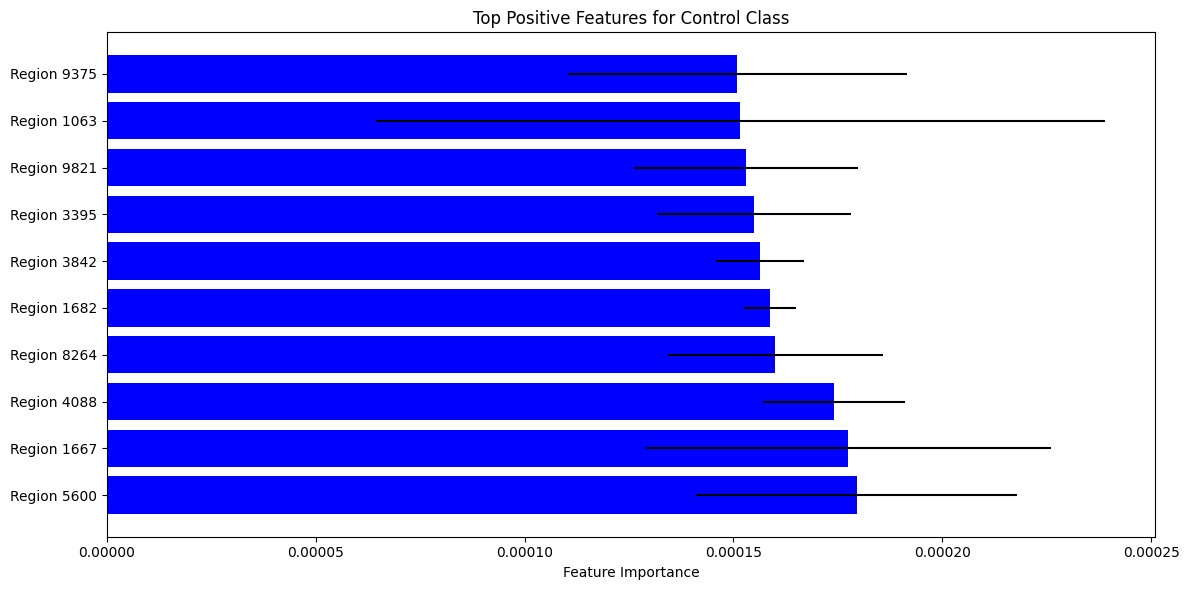

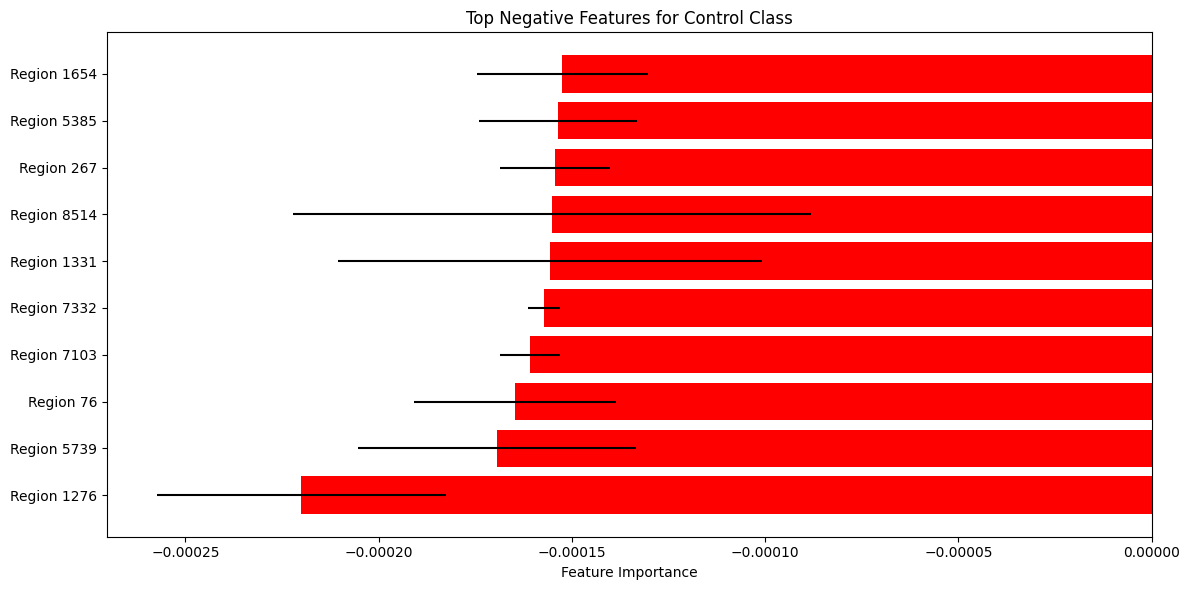

No feature importance found in LIME results
Analysis complete! Check the generated images for OHSU fmri_+_all_features


In [28]:
# Choose which configuration to analyze
center = "OHSU"  # Your center name
config = "fmri_+_all_features"  # Choose which configuration to analyze

# Construct the path to the explanations file
pickle_path = f"lime_results_{center}_{config}/lime_explanations.pkl"

# Run the analysis
results = analyze_saved_lime_explanations(pickle_path)

# Create a network visualization
# You'll need the regions_inds from your model
create_brain_network_visualization(
    lime_results=results,
    regions_inds=regions_inds,  # You need to get this from your model
    atlas_name="CC-200",
    output_file=f"brain_network_{center}_{config}.png"
)

print(f"Analysis complete! Check the generated images for {center} {config}")